Main question: Home vs away's effect on performance. (Does having a race in your country affect performance?)

In [830]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [831]:
races            = pd.read_csv("./dataset/races.csv")
circuits         = pd.read_csv("./dataset/circuits.csv")
constructors     = pd.read_csv("./dataset/constructors.csv")
drivers          = pd.read_csv("./dataset/drivers.csv")
driver_standings = pd.read_csv("./dataset/driver_standings.csv")
demonyms         = pd.read_csv("./dataset/demonyms.csv")

In [832]:
import seaborn as sns
import matplotlib.pyplot as plt

def lookup_country(nationality: str) -> str:
    return demonyms[demonyms['nationality'] == nationality].iloc[0]['country']

def filter_home_or_away_results_only(df, grouping_column, filter_column):
    """Filter out drivers/constructors who have only one at home or not at home
    score remaining.  All drivers/constructors after this filteration should
    have a row at home and outside home"""
    counts = df.groupby([grouping_column])[filter_column].nunique()
    counts = counts[counts > 1]
    return df[df[grouping_column].isin(counts.index)]

def filter_outliers(data, column):
    # Calculate the first and third quartiles of the data
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Filter the data to keep only the rows where the data points fall within the range [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    return data[(data[column] >= q1 - 1.5*iqr) & (data[column] <= q3 + 1.5*iqr)]

def plot_home_vs_away(df, x, y, hue, title):
    # Set the style and context of the plot
    sns.set_style('whitegrid')
    sns.set_context('talk')

    # Create the grouped bar plot using seaborn
    sns.catplot(y=y, x=x, hue=hue, kind='bar', data=df, height=24, orient='h')

    # Set the plot title and axis labels
    plt.title(title)
    plt.ylabel(y)
    plt.xlabel(x)

    # Show the plot
    plt.show()

def plot_hist(df, data_column, grouping_column):
    away_data = df[df[grouping_column] == False][data_column]
    home_data = df[df[grouping_column] == True][data_column]

    plt.hist(away_data, histtype='step')
    plt.hist(home_data, histtype='step')

    plt.title(f'Histogram distribution of {data_column}')
    plt.legend(['Away', 'Home'])
    plt.ylabel(f'Frequency of {data_column}')
    plt.xlabel(data_column)
    plt.show()


##  Driver performance by points

In [833]:
# Alfonso Thiele had an American-Italian citizenship, but he mainly raced for an italian team
# The same applies for Alessandro de Tomaso.
alfonso_index = drivers[(drivers['forename'] == 'Alfonso') & (drivers['surname'] == 'Thiele')].index
alessandro_index = drivers[(drivers['forename'] == 'Alessandro') & (drivers['surname'] == 'de Tomaso')].index

drivers.loc[alfonso_index, 'nationality'] = 'Italian'
drivers.loc[alessandro_index, 'nationality'] = 'Italian'

# There are multiple east german drivers
drivers[drivers['nationality'] == 'East German'] = 'German'

In [834]:
# Convert nationalities to countries and make sure there are no nans.
display(drivers['nationality'])
drivers['country'] = drivers['nationality'].apply(lookup_country)
assert not drivers['country'].hasnans

0         British
1          German
2          German
3         Spanish
4         Finnish
          ...    
852        German
853       Chinese
854         Dutch
855    Australian
856      American
Name: nationality, Length: 857, dtype: object

In [835]:
races.rename(columns={'name':'race_name'}, inplace=True)
races = races[['raceId', 'circuitId', 'year', 'round']]

circuits.rename(columns={'name':'circuit_name'}, inplace=True)
circuits = circuits[['circuitId', 'country']]

races_circuits = pd.merge(races, circuits, on='circuitId', how='left')

display(races_circuits)

,raceId,circuitId,year,round,country
0,1,1,2009,1,Australia
1,2,2,2009,2,Malaysia
2,3,17,2009,3,China
3,4,3,2009,4,Bahrain
4,5,4,2009,5,Spain
...,...,...,...,...,...
1097,1116,69,2023,19,USA
1098,1117,32,2023,20,Mexico
1099,1118,18,2023,21,Brazil
1100,1119,80,2023,22,United States


In [836]:
drivers = drivers[['driverId', 'country']]
drivers.rename(columns={'country': 'driver_country'}, inplace=True)

driver_standings = driver_standings[['raceId', 'driverId', 'points']]

circuits = circuits[['circuitId', 'country']]
circuits.rename(columns={'country': 'circuit_country'}, inplace=True)


# join the dataframes
driver_results = pd.merge(drivers, driver_standings, on='driverId')
driver_race_results = pd.merge(driver_results, races, on='raceId')
driver_circuit_results = pd.merge(driver_race_results, circuits, on='circuitId')
driver_circuit_results.drop(columns=['circuitId'], inplace=True)

display(driver_circuit_results)

df = driver_circuit_results

# Mark each race results as being in the driver's country or not.
df['driver_at_home'] = df['driver_country'] == df['circuit_country']
display(df['driver_at_home'].value_counts())

,driverId,driver_country,raceId,points,year,round,circuit_country
0,1,United Kingdom,18,10.0,2008,1,Australia
1,2,Germany,18,8.0,2008,1,Australia
2,3,Germany,18,6.0,2008,1,Australia
3,4,Spain,18,5.0,2008,1,Australia
4,5,Finland,18,4.0,2008,1,Australia
...,...,...,...,...,...,...,...
33882,725,United Kingdom,825,0.0,1951,1,Switzerland
33883,741,France,825,0.0,1951,1,Switzerland
33884,763,Italy,825,3.0,1951,1,Switzerland
33885,764,France,825,0.0,1951,1,Switzerland


driver_at_home
False    32299
True      1588
Name: count, dtype: int64

In [837]:
# df = df[['driverId', 'raceId', 'year', 'points']]

# df.sort_values(['driverId','year'], ascending=[True,True], inplace=True)
# df['shift'] = df.groupby(['driverId','year'])['points'].shift()
# df['diff'] = df['points'] - df['shift']

df['points'] = df.sort_values(['raceId', 'round']).groupby(['year', 'driverId'])['points'].diff().fillna(0)

df.sort_values(['driverId', 'raceId'])

,driverId,driver_country,raceId,points,year,round,circuit_country,driver_at_home
446,1,United Kingdom,2,0.0,2009,2,Malaysia,False
14898,1,United Kingdom,3,3.0,2009,3,China,False
849,1,United Kingdom,4,5.0,2009,4,Bahrain,False
1272,1,United Kingdom,5,0.0,2009,5,Spain,False
2208,1,United Kingdom,6,0.0,2009,6,Monaco,False
...,...,...,...,...,...,...,...,...
15568,856,Netherlands,1095,0.0,2022,21,Brazil,False
19794,856,Netherlands,1096,0.0,2022,22,UAE,False
1167,856,Netherlands,1098,0.0,2023,1,Bahrain,False
1168,857,Australia,1098,0.0,2023,1,Bahrain,False


In [838]:
# Get driver ids for results at home and outside home.
home_drivers = set(df[df['driver_at_home'] == True]['driverId'])
away_drivers = set(df[df['driver_at_home'] != True]['driverId'])

# Find the intersection: the drivers who've had races in their home country, and in other countries.
international_drivers = home_drivers.intersection(away_drivers)
home_away_results = df[df['driverId'].isin(international_drivers)]

# Group by the driver id and whether they're at home or not, compute the mean
# for all races of the two groups for each driver, then filter such that we get drivers 
# with meaningful points. (There are a lot of them with just zeros)
home_away_results = home_away_results.groupby(['driverId', 'driver_at_home'])
point_means = home_away_results['points'].mean()
point_means = point_means[point_means > 0].to_frame().reset_index()

display(point_means)

point_means = filter_home_or_away_results_only(point_means, 'driverId', 'driver_at_home')

,driverId,driver_at_home,points
0,2,False,1.261364
1,2,True,1.000000
2,3,False,7.417949
3,3,True,5.181818
4,4,False,4.979228
...,...,...,...
249,842,False,2.198113
250,842,True,0.250000
251,845,False,0.050000
252,849,False,0.033333


,count,mean,std,min,25%,50%,75%,max
driver_at_home,,,,,,,,
False,84.0,1.538409,1.888411,0.029703,0.449342,0.912852,1.74566,9.722222
True,84.0,2.008309,3.208458,0.100000,0.519737,1.000000,2.00000,25.500000


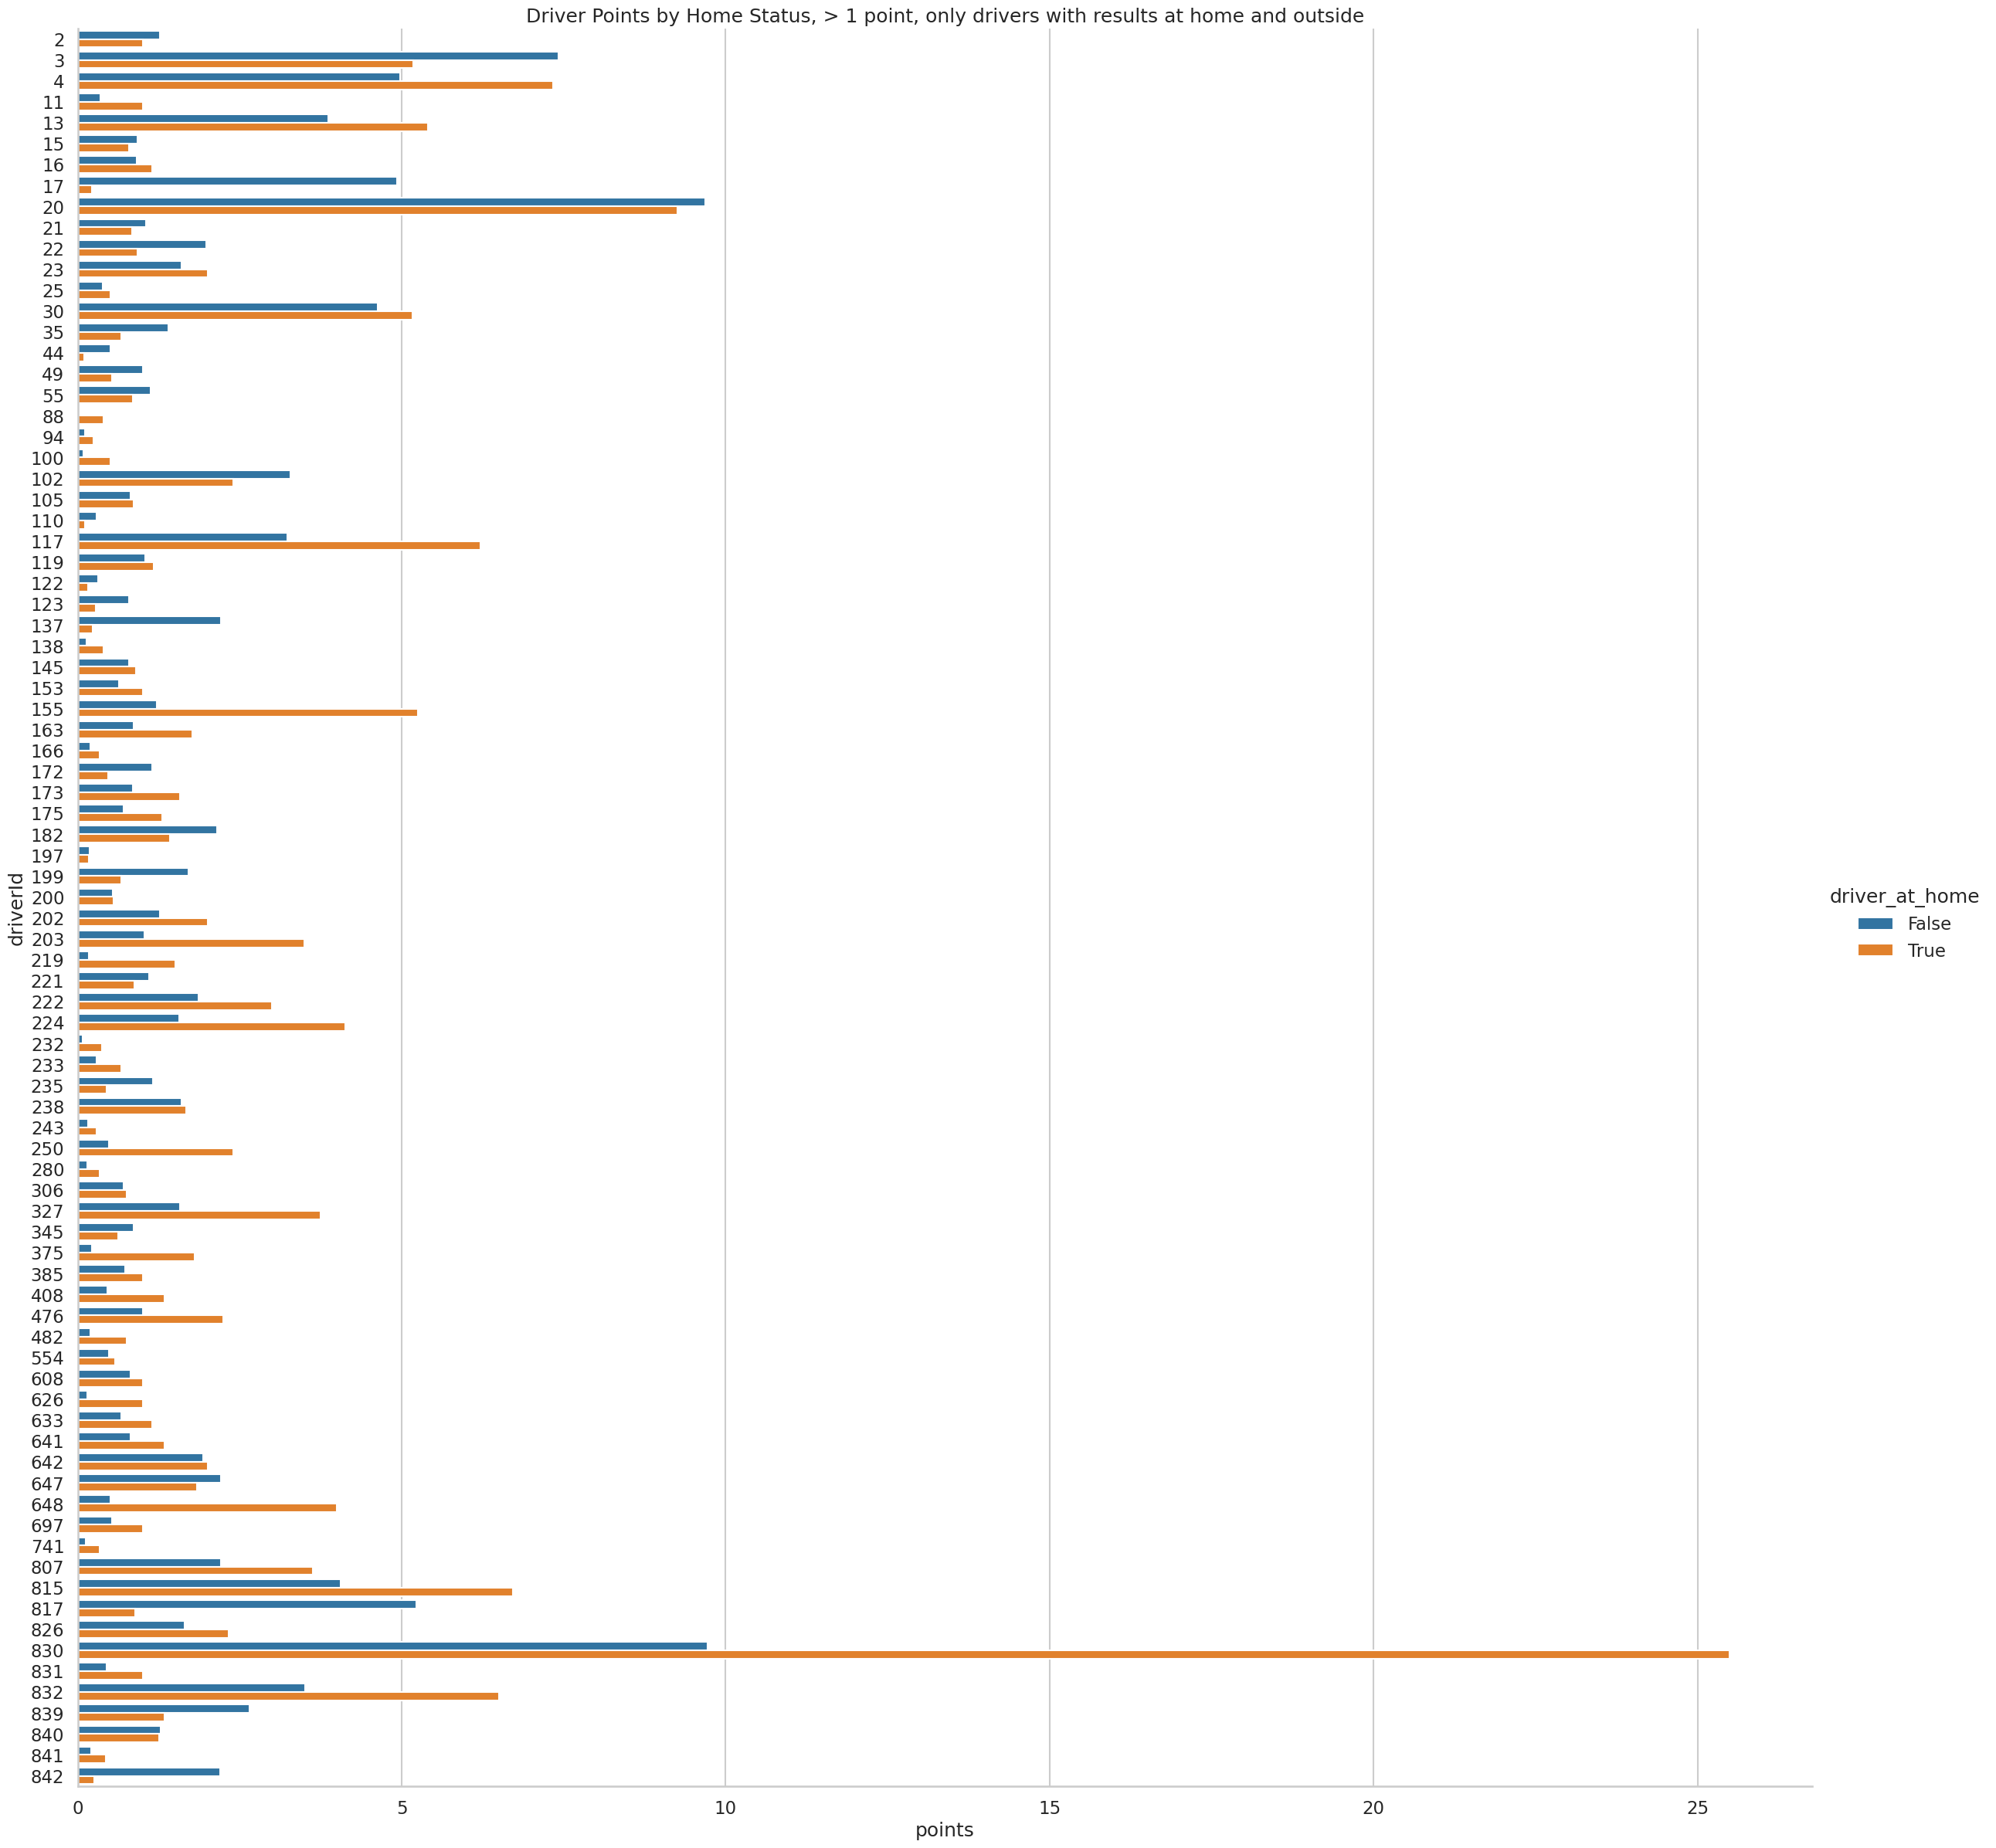

In [839]:
# Notice how there are quite a few outliers?
display(point_means.groupby('driver_at_home')['points'].describe())
plot_home_vs_away(point_means, 'points', 'driverId', 'driver_at_home', 'Driver Points by Home Status, > 1 point, only drivers with results at home and outside')

In [840]:
# The data shows great variation in the values we current have
# might be a good idea to filter it.
home = point_means['driver_at_home'] == True
away = point_means['driver_at_home'] != True

display(point_means.groupby('driver_at_home')['points'].describe())

point_means.loc[home] = filter_outliers(point_means[home], 'points')
point_means.loc[away] = filter_outliers(point_means[away], 'points')

point_means = filter_home_or_away_results_only(point_means, 'driverId', 'driver_at_home')

display(point_means.groupby('driver_at_home')['points'].describe())

,count,mean,std,min,25%,50%,75%,max
driver_at_home,,,,,,,,
False,84.0,1.538409,1.888411,0.029703,0.449342,0.912852,1.74566,9.722222
True,84.0,2.008309,3.208458,0.100000,0.519737,1.000000,2.00000,25.500000


,count,mean,std,min,25%,50%,75%,max
driver_at_home,,,,,,,,
False,72.0,0.927457,0.714104,0.029703,0.334280,0.814474,1.272321,3.284848
True,72.0,1.181618,0.964450,0.100000,0.490385,0.961538,1.517857,4.125000


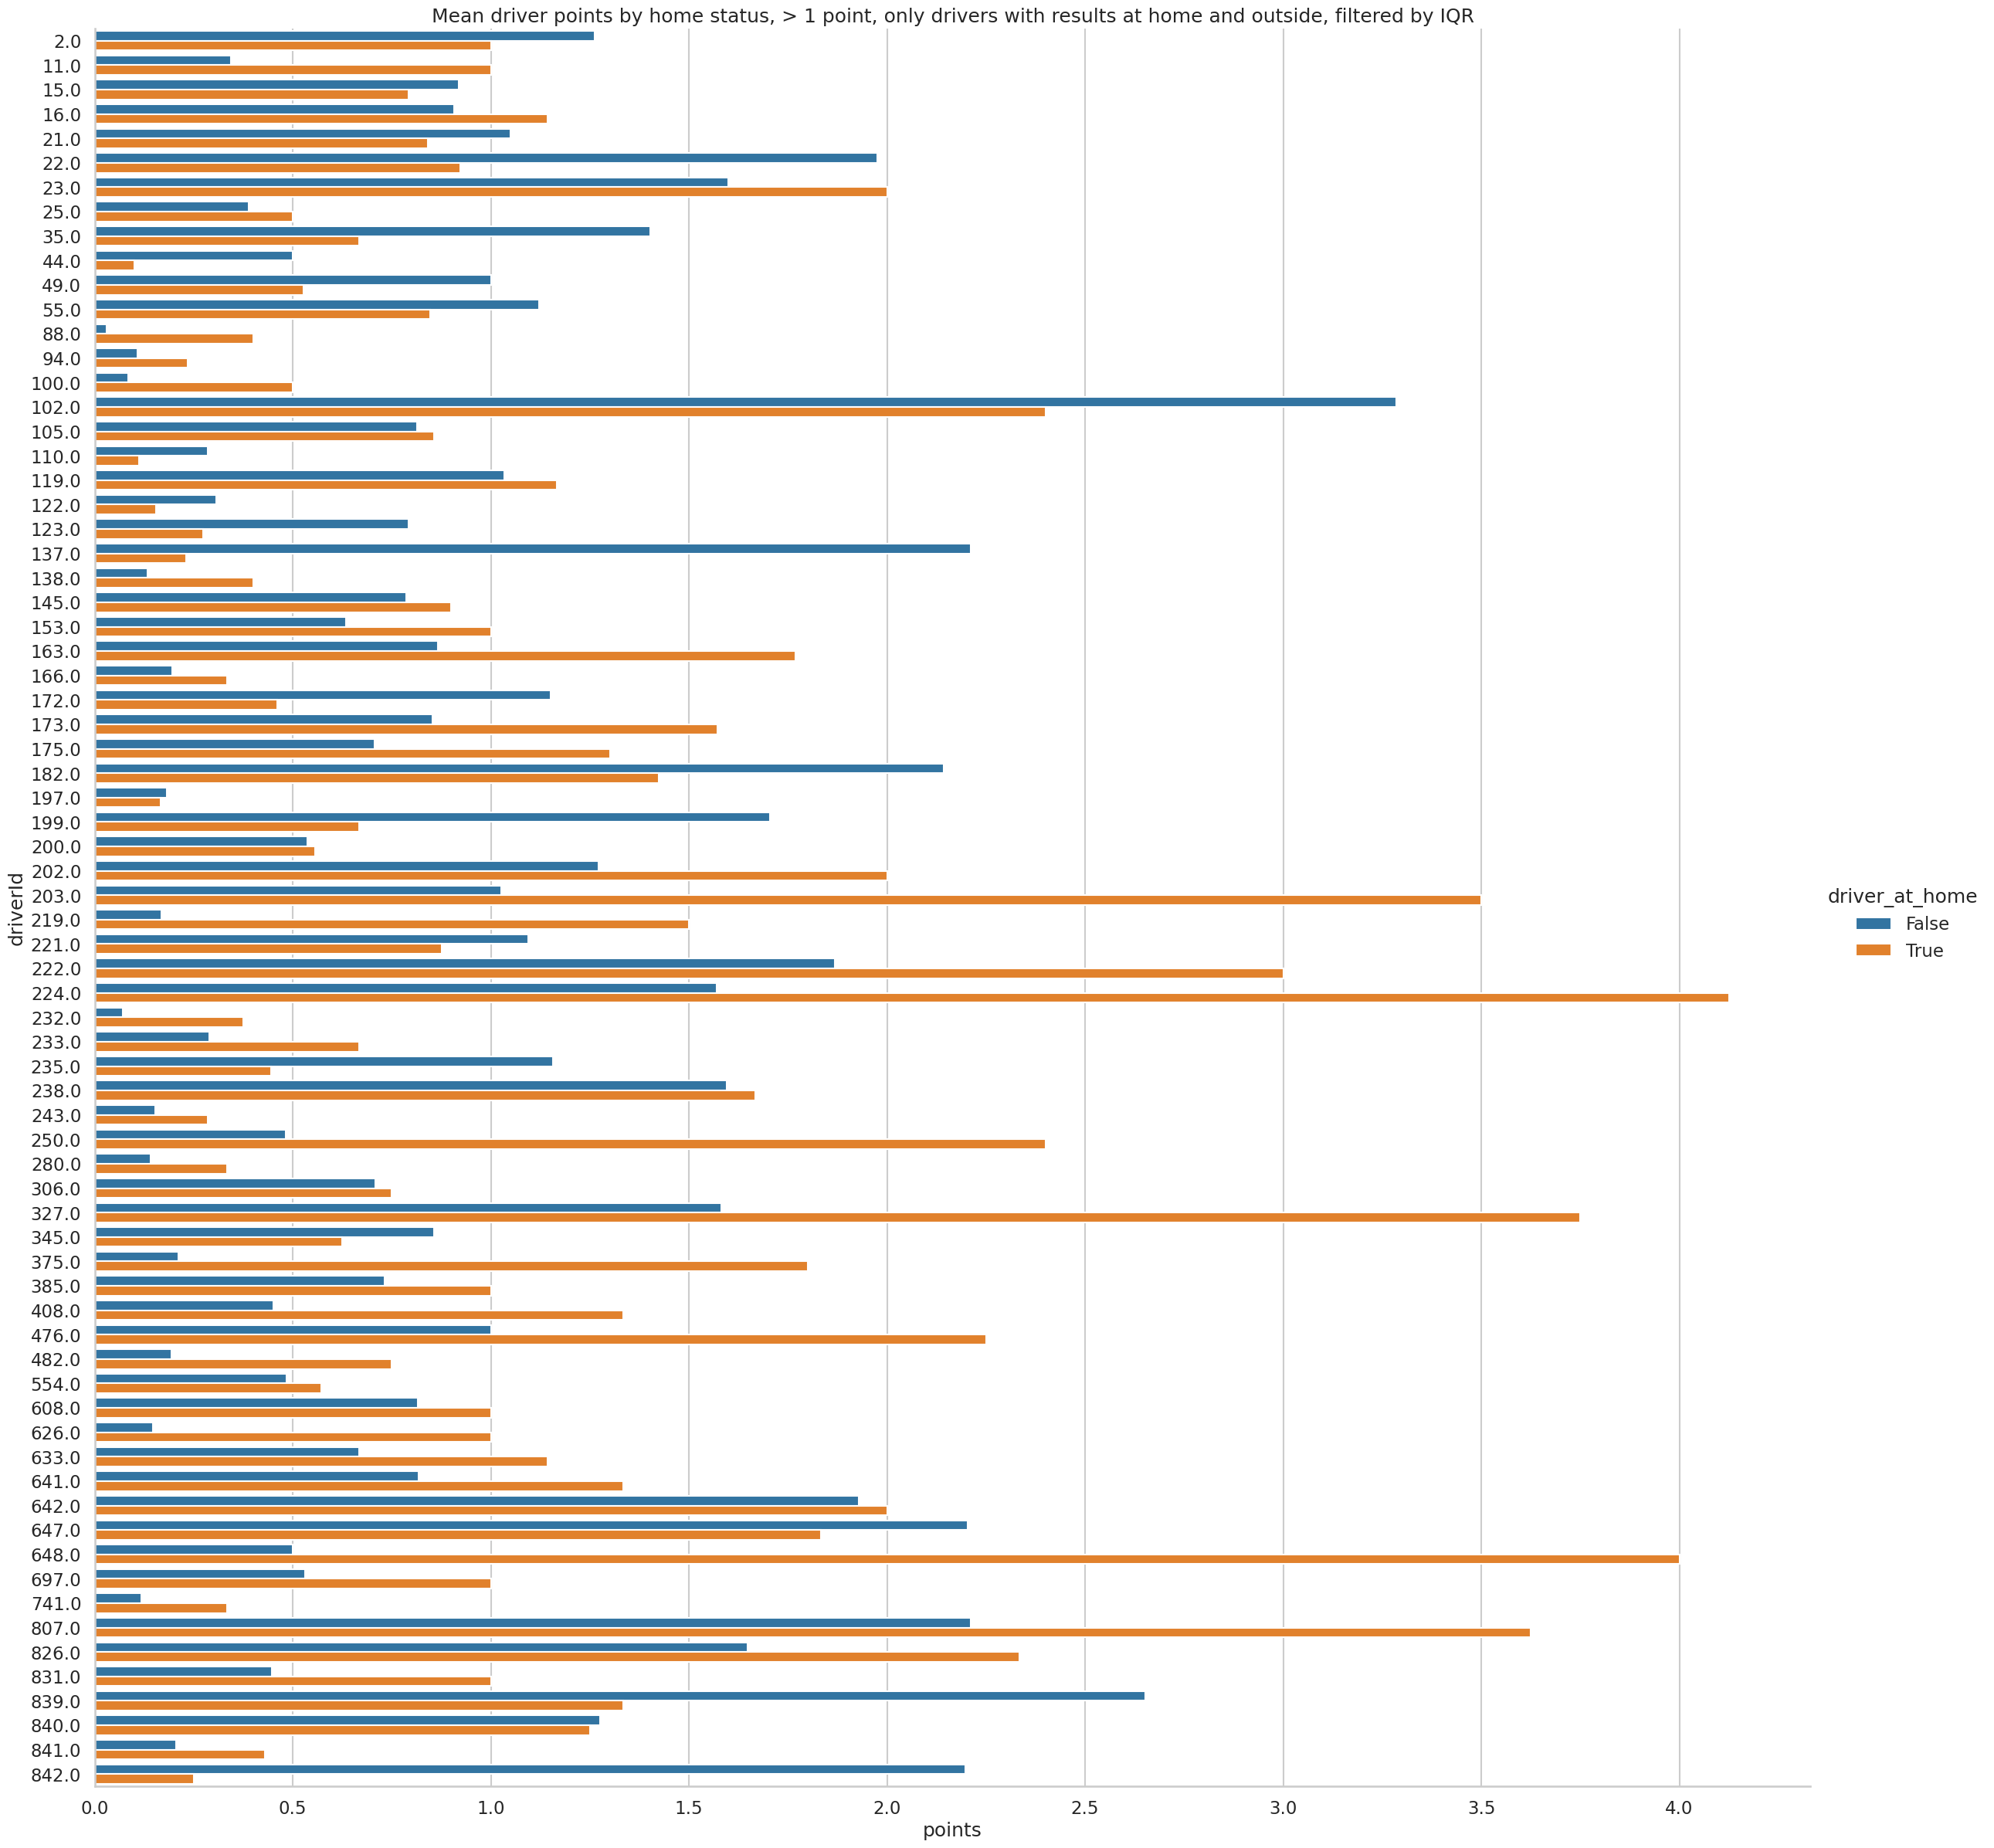

In [841]:
plot_home_vs_away(point_means, 'points', 'driverId', 'driver_at_home',  'Mean driver points by home status, > 1 point, only drivers with results at home and outside, filtered by IQR')

In [842]:
mean_at_home = point_means[point_means['driver_at_home'] == True]['points'].mean()
mean_outside = point_means[point_means['driver_at_home'] != True]['points'].mean()

print(f"Mean points over all drivers and races at home: {mean_at_home}, outside home: {mean_outside}")

Mean points over all drivers and races at home: 1.1816176934997884, outside home: 0.9274568410406326


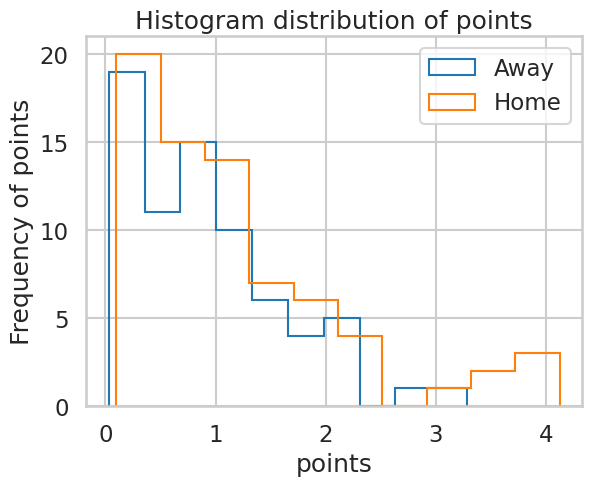

In [843]:
plot_hist(point_means, 'points', 'driver_at_home')

In [844]:
display(point_means)

,driverId,driver_at_home,points
0,2.0,False,1.261364
1,2.0,True,1.000000
9,11.0,False,0.343434
10,11.0,True,1.000000
14,15.0,False,0.918142
...,...,...,...
246,840.0,True,1.250000
247,841.0,False,0.205479
248,841.0,True,0.428571
249,842.0,False,2.198113


In [845]:

import scipy 

# H0: Having a race is your country does not affect how many points you score.
# H1: Having a race in your country results in more points.

home_points = point_means[point_means['driver_at_home'] == True]['points']
away_points = point_means[point_means['driver_at_home'] != True]['points']

alpha = 0.05
t_result = scipy.stats.ttest_ind(home_points, away_points, alternative='greater')

if t_result.pvalue < alpha:
    print(f'One sample T-test p value ({t_result.pvalue}) < alpha ({alpha}). Null hypothesis rejected!')
    print(f"This means that there's enough evidence to say that having a race in your country is likely to cause you to score more points")
else:
    print(f'One sample T-test p value ({t_result.pvalue}) > alpha ({alpha}). Failed to reject null hypothesis!')

One sample T-test p value (0.03722076780015105) < alpha (0.05). Null hypothesis rejected!
This means that there's enough evidence to say that having a race in your country is likely to cause you to score more points


## Constructor performance by wins

In [846]:
constructor_standings = pd.read_csv('./dataset/constructor_standings.csv')
df = pd.merge(constructors, constructor_standings, on='constructorId', how='left')
df = df.merge(races, on='raceId', how='left')
df = df.merge(circuits, on='circuitId', how='left')

df[df['nationality'] == 'East German'] = 'German'
df['constructor_country'] = df['nationality'].apply(lookup_country)
df['constructor_at_home'] = df['constructor_country'] == df['circuit_country']

display(df)

,constructorId,constructorRef,name,nationality,url,constructorStandingsId,raceId,points,position,positionText,wins,circuitId,year,round,circuit_country,constructor_country,constructor_at_home
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,1.0,18.0,14.0,1.0,1,1.0,1.0,2008.0,1.0,Australia,United Kingdom,False
1,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,7.0,19.0,24.0,1.0,1,1.0,2.0,2008.0,2.0,Malaysia,United Kingdom,False
2,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,18.0,20.0,28.0,3.0,3,1.0,3.0,2008.0,3.0,Bahrain,United Kingdom,False
3,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,29.0,21.0,34.0,3.0,3,1.0,4.0,2008.0,4.0,Spain,United Kingdom,False
4,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,40.0,22.0,42.0,3.0,3,1.0,5.0,2008.0,5.0,Turkey,United Kingdom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12988,214,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team,28367.0,1093.0,149.0,4.0,4,0.0,69.0,2022.0,19.0,USA,France,False
12989,214,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team,28377.0,1094.0,153.0,4.0,4,0.0,32.0,2022.0,20.0,Mexico,France,False
12990,214,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team,28387.0,1095.0,167.0,4.0,4,0.0,18.0,2022.0,21.0,Brazil,France,False
12991,214,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team,28397.0,1096.0,173.0,4.0,4,0.0,24.0,2022.0,22.0,UAE,France,False


In [847]:
constructor_ids_at_home = set(df[df['constructor_at_home'] == True]['constructorId'])
constructor_ids_away = set(df[df['constructor_at_home'] != True]['constructorId'])
constructor_ids_home_and_away = constructor_ids_at_home.intersection(constructor_ids_away)
df = df[df['constructorId'].isin(constructor_ids_home_and_away)]

df = filter_home_or_away_results_only(df, 'constructorId', 'constructor_at_home')

display(df)

,constructorId,constructorRef,name,nationality,url,constructorStandingsId,raceId,points,position,positionText,wins,circuitId,year,round,circuit_country,constructor_country,constructor_at_home
884,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber,2.0,18.0,8.0,3.0,3,0.0,1.0,2008.0,1.0,Australia,Germany,False
885,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber,8.0,19.0,19.0,2.0,2,0.0,2.0,2008.0,2.0,Malaysia,Germany,False
886,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber,19.0,20.0,30.0,1.0,1,0.0,3.0,2008.0,3.0,Bahrain,Germany,False
887,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber,30.0,21.0,35.0,2.0,2,0.0,4.0,2008.0,4.0,Spain,Germany,False
888,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber,41.0,22.0,44.0,2.0,2,0.0,5.0,2008.0,5.0,Turkey,Germany,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12988,214,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team,28367.0,1093.0,149.0,4.0,4,0.0,69.0,2022.0,19.0,USA,France,False
12989,214,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team,28377.0,1094.0,153.0,4.0,4,0.0,32.0,2022.0,20.0,Mexico,France,False
12990,214,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team,28387.0,1095.0,167.0,4.0,4,0.0,18.0,2022.0,21.0,Brazil,France,False
12991,214,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team,28397.0,1096.0,173.0,4.0,4,0.0,24.0,2022.0,22.0,UAE,France,False


In [848]:
df = df[['constructorId', 'wins', 'constructor_at_home', 'year', 'raceId', 'round']]

df['wins'] = pd.to_numeric(df['wins'])
df['wins'] = df.sort_values(['raceId', 'round']).groupby(['year', 'constructorId'])['wins'].diff().fillna(0)

# Remove constructors with 0 mean wins.
mean_wins_per_cons = df.groupby('constructorId').aggregate({'wins': 'mean'}).reset_index()
constructor_id_no_wins = mean_wins_per_cons[mean_wins_per_cons['wins'] == 0]['constructorId']
df = df[~df['constructorId'].isin(constructor_id_no_wins)]

df = df[df['wins'] >= 0]
df = filter_home_or_away_results_only(df, 'constructorId', 'constructor_at_home')

display(df)


,constructorId,wins,constructor_at_home,year,raceId,round
884,2,0.0,False,2008.0,18.0,1.0
885,2,0.0,False,2008.0,19.0,2.0
886,2,0.0,False,2008.0,20.0,3.0
887,2,0.0,False,2008.0,21.0,4.0
888,2,0.0,False,2008.0,22.0,5.0
...,...,...,...,...,...,...
12943,213,0.0,False,2022.0,1093.0,19.0
12944,213,0.0,False,2022.0,1094.0,20.0
12945,213,0.0,False,2022.0,1095.0,21.0
12946,213,0.0,False,2022.0,1096.0,22.0


,count,mean,std,min,25%,50%,75%,max
constructor_at_home,,,,,,,,
False,3021.0,0.146309,0.354410,0.0,0.0,0.0,0.0,2.0
True,229.0,0.200873,0.422813,0.0,0.0,0.0,0.0,2.0


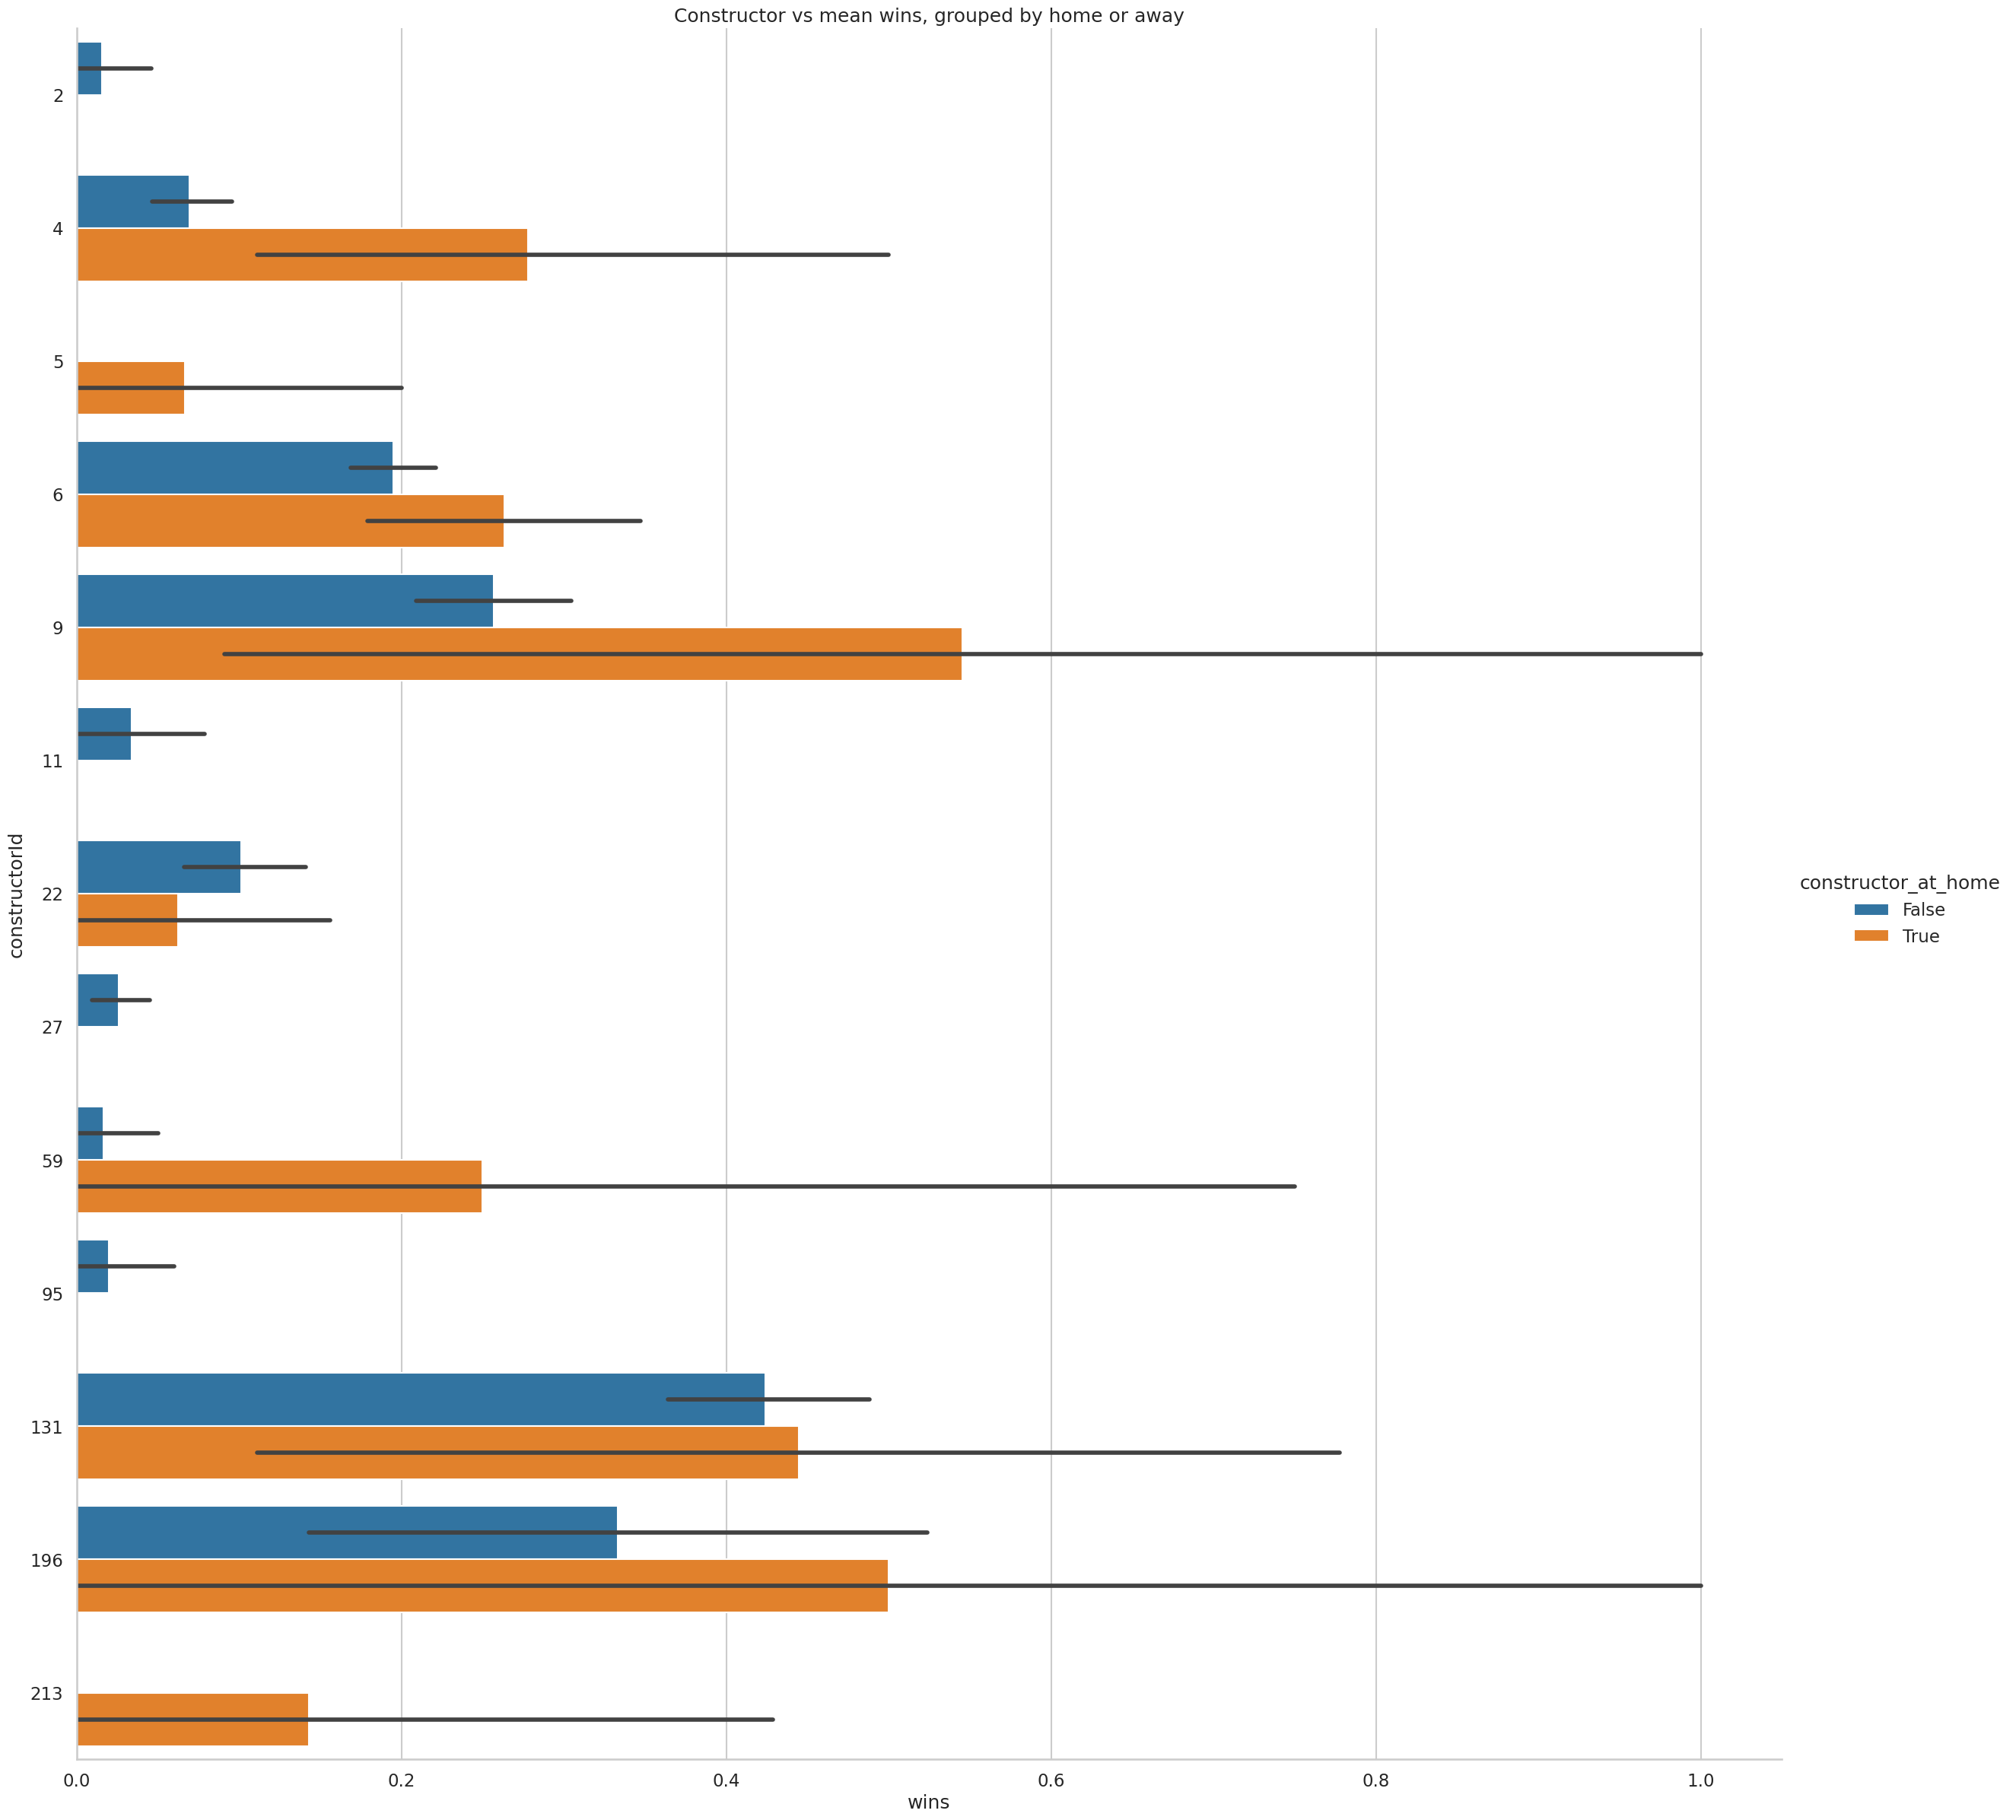

In [849]:
display(df.groupby(['constructor_at_home'])['wins'].describe())
plot_home_vs_away(df, 'wins', 'constructorId', 'constructor_at_home', 'Constructor vs mean wins, grouped by home or away')

In [850]:
# H0: Having a race is your country does not affect how many wins you score.
# H1: Having a race in your country results in more wins.

home_wins = pd.to_numeric(df[df['constructor_at_home'] == True]['wins'])
away_wins = pd.to_numeric(df[df['constructor_at_home'] != True]['wins'])

alpha = 0.05
t_result = scipy.stats.ttest_ind(home_wins, away_wins, alternative='greater')

if t_result.pvalue < alpha:
    print(f'Sample T-test p value ({t_result.pvalue}) < alpha ({alpha}). Null hypothesis rejected!')
else:
    print(f'Sample T-test p value ({t_result.pvalue}) > alpha ({alpha}). Failed to reject null hypothesis!')

Sample T-test p value (0.013463431165676968) < alpha (0.05). Null hypothesis rejected!
